- This workshop should be done groups of 2 as much as possible
- The report should be a pdf export of this notebook (no `.pynb` or `.html`)

**Arthors: Chenxi Deng**

# Content Based Recommendantion

In [ ]:
from IPython.core.display import HTML
import matplotlib.pyplot as plt
HTML(""" 
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

plt.rcParams["figure.figsize"] = (20, 10)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

<div>
<img src="https://miro.medium.com/max/2400/1*BME1JjIlBEAI9BV5pOO5Mg.png" width="300"/>
</div>

## The data

The data comes from imdb. It contains movie titles `title`, associated with their description, cast and director's name, all in a single column called `combined`.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

filepath ="/content/drive/MyDrive/IP_Paris_Class_P2/High_dimension/Recommender"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir(filepath)

In [ ]:
import pickle
import pandas as pd
with open('data/movies_db.pkl','rb') as f:
    movie_database = pd.DataFrame(pickle.load(f))[['title', 'combined']]

In [ ]:
movie_database

,title,combined
0,Avatar,"in the 22nd century, a paraplegic marine is di..."
1,Pirates of the Caribbean: At World's End,"captain barbossa, long believed to be dead, ha..."
2,Spectre,a cryptic message from bond’s past sends him o...
3,The Dark Knight Rises,following the death of district attorney harve...
4,John Carter,"john carter is a war-weary, former military ca..."
...,...,...
5994,Freaks Out,"matilde, cencio, fulvio and mario are family w..."
5995,The Obscure Life of the Grand Duke of Corsica,in 1221 a young man is set on his path to beco...
5996,Son,when a young boy contracts a mysterious illnes...
5997,Moxie,inspired by her mom's rebellious past and a co...


In [ ]:
print("Title\n\t{}".format(movie_database.iloc[0]['title']))
print("Description\n\t{}".format(movie_database.iloc[0]['combined']))

Title
	Avatar
Description
	in the 22nd century, a paraplegic marine is dispatched to the moon pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization. samworthington zoesaldana sigourneyweaver jamescameron action adventure fantasy sciencefiction


## Data preparation

##### Question 1
Use the `TfidfVectorizer` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)) class to create a matrix `matrix` (vector of vectors) where each vector is the bag of word representation of the movie's description with the TfIdf weights. 

##### Solution

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(movie_database['combined'])

In [ ]:
print(X.shape)

(5999, 32396)


## Recommendation

##### Question 2
Create a function `content_based_recommender` which takes a movie title and returns the five closest movies using the distance between the previously computed vectors.

##### Solution

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
Tfid_similarity_matrix = cosine_similarity(X)

In [ ]:
print(Tfid_similarity_matrix[0])

[1.         0.0293372  0.01226677 ... 0.         0.         0.        ]


In [ ]:
def content_based_recommender(movie):
    index = movie_database[movie_database['title'] == movie].index[0]
    distance = sorted(list(enumerate(Tfid_similarity_matrix[index])),reverse=True,key = lambda x: x[1])
    for i in distance[1:7]:
        print(movie_database.iloc[i[0]].title)

In [ ]:
# Testing the recommender engine
# Depending on your distance metric you can have different results
content_based_recommender('Man of Steel')

Batman v Superman: Dawn of Justice
Midnight Special
The Chronicles of Riddick
Sunshine
The Cold Light of Day
Zack Snyder's Justice League


##### Question 3
In a production setting (real time answers, lots of users etc.):
- What are the advantages/drawbacks of this approach ?
- Which solution can we use to reduce these drawbacks ?

##### Answer

**Advantages**:
1. In practice, scaling the recommender system to accommondate a large number of users might be computationaly challenging. Content-based recommender doesn't require data about other users. It is therefore much easy to scale. 

2. The model makes recommendation that uses information provided by a particular user. It is therefore highly personalised. This is also more transparent, as it recommends solely based on features of that particular user. 

**Disadvantages**:
1. This system is largely dependent on user input. If a user doesn't frequently visit the site or someone who has never visited the site, the amount of data we have would be extremely limited. This can therefore impact on the accuracy of our prediction.


2. This model makes recommendation based on existing information we have about the user, which makes it hard to expand on the interest/predict trend. 

3. This model cannot work with unstructured data. 

**Solution**:

One solution to these problems could be to incorporate linked data cloud into the information filtering using a semantic space vector model. We can use information from linked data cloud as source for engineering user profiles as well as enriching the description of unstructured items. 
*Reference: Zitouni H, Meshoul S & Taouche K (2017) Improving content based recommender systems using linked data cloud and FOAF vocabulary. In Proceedings of the International Conference on Web Intelligence pp 988–992. New York, NY, USA: Association for Computing Machinery



# Collaborative Filtering

<div>
<img src="https://miro.medium.com/max/2400/1*x8gTiprhLs7zflmEn1UjAQ.png" width="400"/>
</div>


## The data

The data comes from the [Book Recommendation Dataset](https://www.kaggle.com/arashnic/book-recommendation-dataset?select=Ratings.csv).

In [ ]:
#pip uninstall pandas

Found existing installation: pandas 1.1.5
Uninstalling pandas-1.1.5:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/pandas-1.1.5.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pandas/*
Proceed (y/n)? y
  Successfully uninstalled pandas-1.1.5


In [ ]:
import pandas as pd

read_params = {"sep":';', "on_bad_lines":'skip', "encoding":"latin-1", "compression": "gzip", "low_memory":False}
rating = pd.read_csv('data/BX-Book-Ratings.csv.gz', **read_params)
user = pd.read_csv('data/BX-Users.csv.gz', **read_params)
book = pd.read_csv('data/BX-Books.csv.gz', **read_params)

book['Book-ID'] = book.index

cols = ['Year-Of-Publication', 'Publisher', 'Book-Author', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']
book_rating = pd.merge(rating, book, on='ISBN').drop(cols, axis=1)

In [ ]:
rating.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
user.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
book.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Book-ID
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,1
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,2
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,3
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,4


---

##### Be careful, some books are published by multiple publisher. Let's say these are different books.

In [ ]:
book[book['Book-Title'] == "Skipping Christmas"]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Book-ID
758,0385505833,Skipping Christmas,JOHN GRISHAM,2001,Doubleday,http://images.amazon.com/images/P/0385505833.0...,http://images.amazon.com/images/P/0385505833.0...,http://images.amazon.com/images/P/0385505833.0...,758
1451,0385508417,Skipping Christmas,JOHN GRISHAM,2002,Doubleday,http://images.amazon.com/images/P/0385508417.0...,http://images.amazon.com/images/P/0385508417.0...,http://images.amazon.com/images/P/0385508417.0...,1451
46560,0553712837,Skipping Christmas,John Grisham,2001,Bantam Books-Audio,http://images.amazon.com/images/P/0553712837.0...,http://images.amazon.com/images/P/0553712837.0...,http://images.amazon.com/images/P/0553712837.0...,46560
51157,0375431624,Skipping Christmas,JOHN GRISHAM,2001,Random House Large Print,http://images.amazon.com/images/P/0375431624.0...,http://images.amazon.com/images/P/0375431624.0...,http://images.amazon.com/images/P/0375431624.0...,51157
79978,0739301985,Skipping Christmas,JOHN GRISHAM,2002,Random House Audio,http://images.amazon.com/images/P/0739301985.0...,http://images.amazon.com/images/P/0739301985.0...,http://images.amazon.com/images/P/0739301985.0...,79978
266661,0739420712,Skipping Christmas,John Grisham,2001,Doubleday,http://images.amazon.com/images/P/0739420712.0...,http://images.amazon.com/images/P/0739420712.0...,http://images.amazon.com/images/P/0739420712.0...,266661


In [ ]:
book_rating.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-ID
0,276725,034545104X,0,Flesh Tones: A Novel,2966
1,2313,034545104X,5,Flesh Tones: A Novel,2966
2,6543,034545104X,0,Flesh Tones: A Novel,2966
3,8680,034545104X,5,Flesh Tones: A Novel,2966
4,10314,034545104X,9,Flesh Tones: A Novel,2966


## Data Preparation

##### Question 1
 - Add a column `RatingCount_book` to `book_rating` containing the count of ratings of the corresponding book. The new dataframe will be called `user_rating`
 - Filter out books where the number of rating is below `30`
 
|    |   Book-ID |   RatingCount_book |   User-ID |       ISBN |   Book-Rating | Book-Title             |
|---:|----------:|-------------------:|----------:|-----------:|--------------:|:-----------------------|
|  0 |         5 |                 33 |         8 | 0399135782 |             0 | The Kitchen God's Wife |
|  1 |         5 |                 33 |     11676 | 0399135782 |             9 | The Kitchen God's Wife |
|  2 |         5 |                 33 |     29526 | 0399135782 |             9 | The Kitchen God's Wife |
|  3 |         5 |                 33 |     36836 | 0399135782 |             0 | The Kitchen God's Wife |
|  4 |         5 |                 33 |     46398 | 0399135782 |             9 | The Kitchen God's Wife |


###### Solution

In [ ]:
#book_rating["RatingCount_book"] = book_rating.groupby('ISBN')['ISBN'].transform('count')
book_rating.loc[:,"RatingCount_book"] = book_rating.groupby('ISBN')['ISBN'].transform('count')

In [ ]:
user_rating = book_rating[(book_rating['RatingCount_book']>=30)]

In [ ]:
user_rating.sort_values(by=['RatingCount_book'],ascending=False).tail()

,User-ID,ISBN,Book-Rating,Book-Title,Book-ID,RatingCount_book
330464,48975,0449214176,0,Bluebeard's Egg and Other Stories,6421,30
330463,38887,0449214176,7,Bluebeard's Egg and Other Stories,6421,30
330462,35050,0449214176,0,Bluebeard's Egg and Other Stories,6421,30
330461,33958,0449214176,0,Bluebeard's Egg and Other Stories,6421,30
23675,72287,0399148450,0,Widow's Walk (Spenser Mysteries (Hardcover)),7740,30


In [ ]:
user_rating.shape

(315065, 6)

##### Question 2
 - Add a column `RatingCount_user` to `user_rating` containing the count of ratings made by the user. The new dataframe will be called `final_df`
 - Filter out users where the number of rating is below `20`

 
|    |   Book-ID |   RatingCount_book |   User-ID |       ISBN |   Book-Rating | Book-Title                                                    |   RatingCount_user |
|---:|----------:|-------------------:|----------:|-----------:|--------------:|:--------------------------------------------------------------|-------------------:|
|  0 |         5 |                 33 |     11676 | 0399135782 |             9 | The Kitchen God's Wife                                        |               2495 |
|  1 |        18 |                422 |     11676 | 0440234743 |             9 | The Testament                                                 |               2495 |
|  2 |        19 |                180 |     11676 | 0452264464 |             8 | Beloved (Plume Contemporary Fiction)                          |               2495 |
|  3 |        21 |                 37 |     11676 | 1841721522 |            10 | New Vegetarian: Bold and Beautiful Recipes for Every Occasion |               2495 |
|  4 |        26 |               2502 |     11676 | 0971880107 |             6 | Wild Animus                                                   |               2495 |

##### Solution

In [ ]:
user_rating.loc[:, 'RatingCount_user'] = user_rating.groupby('User-ID')['Book-Rating'].transform('count')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [ ]:
final_df = user_rating[(user_rating['RatingCount_user']>=20)]

In [ ]:
final_df.sort_values(by=['RatingCount_user'],ascending=False).tail()

,User-ID,ISBN,Book-Rating,Book-Title,Book-ID,RatingCount_book,RatingCount_user
514881,189666,1401088945,0,Ground Zero and Beyond,24956,68,20
317323,144194,0440972329,0,A Ring of Endless Light (Austin Family),5553,33,20
514887,211961,1401088945,0,Ground Zero and Beyond,24956,68,20
150133,198930,0441005764,8,"Mossflower (Redwall, Book 2)",3242,46,20
271140,98930,0060921145,0,Animal Dreams,6628,166,20


##### Question 3
Normalize the `Book-Rating` column using `MinMaxScaler` of `sklearn` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)) and put the value in the column `Book-Rating-Scaled`

##### Solution

In [ ]:
final_df['Book-Rating'].shape

(193475,)

In [ ]:
import numpy as np

In [ ]:
dat = np.array(final_df['Book-Rating'].values.reshape(-1, 1))

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
final_df.loc[:,'Book-Rating-Scaled'] = scaler.fit_transform(dat)

In [ ]:
final_df.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-ID,RatingCount_book,RatingCount_user,Book-Rating-Scaled,User-ID-Continuous,Book-ID-Continuous
2,6543,034545104X,0,Flesh Tones: A Novel,2966,60,146,0.0,43,858
4,10314,034545104X,9,Flesh Tones: A Novel,2966,60,92,0.9,81,858
5,23768,034545104X,0,Flesh Tones: A Novel,2966,60,561,0.0,189,858
7,28523,034545104X,0,Flesh Tones: A Novel,2966,60,89,0.0,234,858
14,77480,034545104X,8,Flesh Tones: A Novel,2966,60,62,0.8,698,858


---

In [ ]:
# For later usage
# convert userID to continuous sequence of ID
codes_user, uniques_user = pd.factorize(final_df['User-ID'], sort=True)
final_df['User-ID-Continuous'] = codes_user

# convert bookID to continuous sequence of ID
codes_book, uniques_book = pd.factorize(final_df['Book-ID'], sort=True)
final_df['Book-ID-Continuous'] = codes_book

In [ ]:
# Split the dataset in train/validation
split = pd.np.random.rand(len(final_df)) < 0.8
train = final_df[split]
valid = final_df[~split]
print(train.shape , valid.shape)

(154506, 10) (38969, 10)


## Matrix Factorization

<div>
<img src="https://miro.medium.com/max/2000/1*WrOoSr49lQs43auSsLlLdg.png" width="800"/>
</div>

### Training

In [ ]:
import tensorflow as tf 
from tensorflow import keras

# Hyperparameters
DIM_LATENT = 100
EPOCHS = 1000
BATCH_SIZE = 32
INITIAL_LR = 10**-4

NB_USER = final_df.nunique()["User-ID-Continuous"]
NB_BOOK = final_df.nunique()['Book-ID-Continuous']

# Inputs
user_input = keras.layers.Input(shape=(1,), name='user_input', dtype='int64')
book_input = keras.layers.Input(shape=(1,), name='book_input', dtype='int64')

# Bias
user_bias = keras.layers.Embedding(NB_USER, 1)(user_input)
book_bias = keras.layers.Embedding(NB_BOOK, 1)(book_input)

# Embbeddings
user_embedding=keras.layers.Embedding(NB_USER,
                                      DIM_LATENT,
                                      name='user_embedding',
                                      embeddings_initializer="he_normal",
                                      embeddings_regularizer=keras.regularizers.l2(1e-6),
                                     )(user_input)

book_embedding=keras.layers.Embedding(NB_BOOK,
                                     DIM_LATENT,
                                     name='book_embedding',
                                     embeddings_initializer="he_normal",
                                     embeddings_regularizer=keras.regularizers.l2(1e-6),
                                    )(book_input)

# Flattening 
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)
book_vec = keras.layers.Flatten(name='FlattenBooks')(book_embedding)

# Dot product between the two matrixes
dot_user_book = tf.tensordot(user_vec, book_vec, 2)

# Add all the components (including bias)
x = dot_user_book + user_bias + book_bias

# The sigmoid activation forces scores to be in [0, 1]
output = tf.nn.sigmoid(x)

mf_model = keras.models.Model([user_input, book_input], output)

mf_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=INITIAL_LR)
)

# Earl stopping in order to stop training when overfitting begins. 
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

# Fit the model 
history = mf_model.fit(
    [train['User-ID-Continuous'],train['Book-ID-Continuous']],
    train['Book-Rating-Scaled'],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=([valid['User-ID-Continuous'],
                      valid['Book-ID-Continuous']],
                      valid['Book-Rating-Scaled']),
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/1000
4844/4844 [==============================] - 54s 11ms/step - loss: 0.6801 - val_loss: 0.6583
Epoch 2/1000
4844/4844 [==============================] - 50s 10ms/step - loss: 0.5769 - val_loss: 0.5480
Epoch 3/1000
4844/4844 [==============================] - 52s 11ms/step - loss: 0.5301 - val_loss: 0.5402
Epoch 4/1000
4844/4844 [==============================] - 51s 11ms/step - loss: 0.5239 - val_loss: 0.5332
Epoch 5/1000
4844/4844 [==============================] - 49s 10ms/step - loss: 0.5185 - val_loss: 0.5280
Epoch 6/1000
4844/4844 [==============================] - 50s 10ms/step - loss: 0.5133 - val_loss: 0.5233
Epoch 7/1000
4844/4844 [==============================] - 50s 10ms/step - loss: 0.5090 - val_loss: 0.5195
Epoch 8/1000
4844/4844 [==============================] - 48s 10ms/step - loss: 0.5046 - val_loss: 0.5157
Epoch 9/1000
4844/4844 [==============================] - 52s 11ms/step - loss: 0.5007 - val_loss: 0.5118
Epoch 10/1000
4844/4844 [=====================

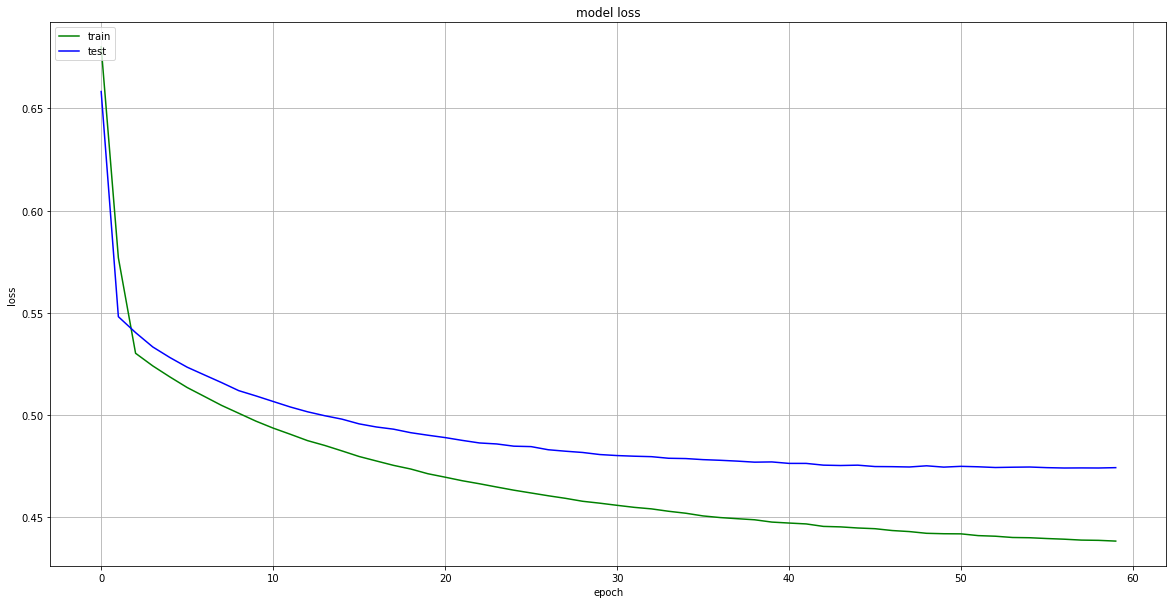

In [ ]:
# Plot learning curve
plt.plot(history.history['loss'] , 'g')
plt.plot(history.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

### Prediction

##### Question 1
Write a method called `mf_recommender` which
 - takes a user `U` using its continuous index (from 0 to `NB_USER`)
 - finds the 10 closest users to `U`
 - returns the best book unread by `U` and rated by more than 3 of these 10 closest users

**Hint**
To get the users embeddings
```python
user_emb_layer = model.get_layer('user_embedding')
user_emb_weight = user_emb_layer.get_weights()[0]
```

##### Solution

In [ ]:
# get user embeddings
user_emb_layer = mf_model.get_layer('user_embedding')
user_emb_weight = user_emb_layer.get_weights()[0]

In [ ]:
user_emb_weight.shape

(2600, 100)

In [ ]:
# use knn to get closest users 
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(metric='cosine',algorithm='auto').fit(user_emb_weight)
distances, indices = knn.kneighbors(user_emb_weight,n_neighbors=11)

In [ ]:
def best_rated_book(booklist,df):
  best_rated, best_avg_rating =None, 0
  for book in booklist:
    rating_count = df.loc[df['Book-ID']==book,'Rating_count'].iloc[0]
    total_ratings = df.loc[df['Book-ID']==book,'Book-Rating'].sum()
    average_rating = total_ratings/rating_count
    if average_rating > best_avg_rating:
      best_avg_rating = average_rating
      best_rated = book 
  return best_rated, best_avg_rating

In [ ]:
def mf_recommender(user_id = int):
  cloest_users = [i.tolist() for i in indices if user_id == i.tolist()[0]][0]
  ten_cloest = cloest_users[1:]
  # return books that have been read by the user  
  readbooks = set(final_df.loc[final_df['User-ID-Continuous'] == user_id,'Book-ID'])
  # return all books that have been rated by the 10 closest users 
  allbooks = final_df.loc[final_df['User-ID-Continuous'].isin(ten_cloest)]
  # return books that have been rated by the close users and not been read by our user 
  unreadbooks = allbooks.loc[~allbooks['Book-ID'].isin(readbooks)]
  unreadbooks.loc[:,'Rating_count'] = unreadbooks.groupby('Book-ID')['Book-ID'].transform('count')
  final_booklist = set(unreadbooks.loc[(unreadbooks['Rating_count']>3),'Book-ID'].tolist())

  best_rated, best_avg_rating = best_rated_book(final_booklist,unreadbooks)
  id  = unreadbooks.loc[unreadbooks['Book-ID'] == best_rated,'Book-ID'].head(1).to_string(index=False)
  bookt=unreadbooks.loc[unreadbooks['Book-ID'] == best_rated,'Book-Title'].head(1).to_string(index=False)
  count = unreadbooks.loc[unreadbooks['Book-ID'] == best_rated,'Rating_count'].head(1).to_string(index=False)

  print(f'Book-ID\t\t{id}')
  print(f'Book-Title\t{bookt}')
  print(f'mean\t\t{best_avg_rating}')
  print(f'count\t\t{count}')


In [ ]:
mf_recommender(0)

Book-ID		748
Book-Title	The Da Vinci Code
mean		4.75
count		4


##### Question 2
Write a method `mf_book_recommender` which takes a book name and returns the 5 closest book names. If multiple pushishers published the same book (the title is the same), take the most rated book.

##### Solution

In [ ]:
book_emb_layer = mf_model.get_layer('book_embedding')
book_emb_weight = book_emb_layer.get_weights()[0]

# use knn to get closest books 
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(metric='cosine',algorithm='brute').fit(book_emb_weight)
distances, indices = knn.kneighbors(book_emb_weight,n_neighbors=6)

In [ ]:
# get the most rated book if the title is the same 
def most_rated(booktitle):
  most_rated = final_df.loc[final_df['Book-Title'] == booktitle]
  return most_rated.loc[most_rated['RatingCount_book'].idxmax(),"Book-ID-Continuous"]
  
def mf_book_recommender(booktitle):
  candidate_books = []
  book_id = most_rated(booktitle)
  for i in indices:
    if int(book_id) == i.tolist()[0]:
      for j in i:
        candidate_books.append(final_df.loc[final_df['Book-ID-Continuous'] == j,'Book-Title'].head(1).to_string(index=False))
  print(candidate_books[1:])

In [ ]:
mf_book_recommender("1984")

['Tropic of Cancer', 'Apollo 13 : Lost Moon', 'SHIPPING NEWS', 'Picture of Dorian Gray', 'An Ocean Apart']


In [ ]:
mf_book_recommender("Harry Potter and the Chamber of Secrets (Book 2)")

['The God of Small Things', 'Haunting Rachel', 'Cry Wolf', 'Punish the Sinners', 'Mercy']


**Alternative implementation**

In [ ]:
from sklearn.metrics import pairwise_distances


def mf_book_recommender_knn(book_title):
  book_emb_layer = mf_model.get_layer('book_embedding')
  book_emb_weight = book_emb_layer.get_weights()[0]
  aux_df = final_df.loc[final_df['Book-Title']==book_title]
  book_id = int(aux_df.loc[aux_df['RatingCount_book'] == aux_df['RatingCount_book'].max()]['Book-ID-Continuous'].to_numpy()[0])
  book_emb_vec = [book_emb_layer(book_id)]
  unique_book_ids = np.unique(final_df['Book-ID-Continuous'].to_numpy(),axis=0)
  embedding_matrix = book_emb_layer(unique_book_ids)
  neigh = NearestNeighbors(n_neighbors=6)
  neigh.fit(embedding_matrix)
  _5_closest_ids = neigh.kneighbors(book_emb_vec)[1].flatten()
  _5_closest_books = np.unique(final_df.loc[final_df['Book-ID-Continuous'].isin(_5_closest_ids)]['Book-Title'])
  return _5_closest_books

def mf_book_recommender_2(book_title):
  book_emb_layer = mf_model.get_layer('book_embedding')
  book_emb_weight = book_emb_layer.get_weights()[0]
  aux_df = final_df.loc[final_df['Book-Title']==book_title]
  book_id = int(aux_df.loc[aux_df['RatingCount_book'] == aux_df['RatingCount_book'].max()]['Book-ID-Continuous'].to_numpy()[0])
  book_emb_vec = book_emb_layer(book_id).numpy().reshape(1,-1)
  unique_book_ids = np.unique(final_df['Book-ID-Continuous'].to_numpy(),axis=0)
  embedding_matrix = book_emb_layer(unique_book_ids).numpy()
  distance_matrix = pairwise_distances(embedding_matrix, book_emb_vec, metric='l2')
  #distance_matrix = np.diag(np.dot((embedding_matrix - book_emb_vec), (embedding_matrix - book_emb_vec).T))
  _5_closest_ids = np.argsort(distance_matrix, axis=0).flatten()[:6]
  _5_closest_books = np.unique(final_df.loc[final_df['Book-ID-Continuous'].isin(_5_closest_ids)]['Book-Title'])
  return _5_closest_books

##### Question 3
In a production setting (real time answers, lots of users etc.):
- What are the advantages/drawbacks of this approach ?
- Which solution can we use to reduce these drawbacks ?

##### Answer

**Advantages**: 
1. This method only uses observed feedbacks to train a mf model and doesn't require any information about users or items and therefore can be easily adapted to accommodate different circumstances.

2. The embeddings are automatically learnt so that we don't need domain knowledge. 

3. In contrast to content-based filtering, this model can help users to discover new items. 

**Disadvantages**:
1. As we saw above, the prediction is given based on similarity scores. If an item or an user is not seen during the training, the model cannot make queries about this item. 

2. This model cannot incorporate features about the users or the items that could potentially improve the model. 

3. This model might also suffer from data sparsity as most users do not give ratings or reviews to the items. 

4. This model might have to constantly retrained as new items and users entering the dataset. 

**Solution**:

One solution to some of the issues above is to use the WALS algorithm so that every time we try to add a new item or a new user into the system, we only learn an embedding without having to retrain the model (reference: https://research.tilburguniversity.edu/en/publications/wals-prediction):

$min_{v_{i_0} \in \mathbb{R^d}} ||A_{i_0} - U_{v_{i_0}}||$

Additionally, if a system does not have the interactions of an user or an item, we can approximate its embedding by averaging the embeddings of items from the same category. 

# Deep Neural Network Based Recommendation Systems

![](https://miro.medium.com/max/700/1*sTBtqrsQzTKlZ8hSU7I6FQ.png)

## The data

The train data are orders from **2019-08-04**, and the test data are orders from **2019-08-05**

##### Lines

The data is contructed as follow:

- We collect every order of one day
- For each order we collect features of the user, the context and the related sales
- We pick a random sales which did not generate an order for the same user at the same time and compute the same features

We describe these two sales as positive item for the first one and negative item for the second one.

##### Columns

Here the features are anonymize and scaled. They describe different things such as:
 - The sales: the brand, the sector, the popularity of the sale at the order time,  etc.
 - The user: gender, age etc.
 - The past sales that the user viewed / bought from

In [ ]:
X = pd.read_csv('data/2019-08-04_anon.csv.gz', compression="gzip", index_col=0)
X.shape

(98430, 354)

In [ ]:
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,label
0,0.004651,0.000838,0.000918,0.011108,0.200549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.006173,0.200000,0.001812,0.150000,0.002144,0.150000,0.024321,0.717033,0.011494,0.200000,0.002591,0.150000,0.003188,0.150000,0.030599,0.717033,0.090909,0.200000,0.029126,0.150000,0.032258,0.150000,0.030599,0.717033,0.000000,0.000000,0.000000,...,0.032927,0.118435,0.034467,0.115075,0.019608,0.039459,0.0,0.000761,0.061674,0.715068,0.061674,0.715068,0.000000,1.00000,0.061674,0.715068,0.000496,0.00000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.0,0.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000,0.003820,0.000000,-1.000000,0.359694,-1.000000,0.498907,0.666667,0
1,0.007442,0.000503,0.000551,0.011749,0.582418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.012346,0.250000,0.001812,0.250000,0.002144,0.250000,0.029151,0.719780,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.004274,0.000613,0.000710,...,0.005357,0.015723,0.003968,0.009292,0.008000,0.004109,0.0,0.000640,0.000000,1.000000,0.230366,0.104110,0.000000,1.00000,0.382199,0.104110,0.000000,0.00000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.0,0.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000,0.006875,0.000000,-1.000000,0.085641,-1.000000,0.645773,0.333333,1
2,0.006512,0.000335,0.000275,0.040644,0.085165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.006173,0.142857,0.000604,0.125000,0.000715,0.166667,0.009038,0.085165,0.011494,0.142857,0.000864,0.125000,0.001063,0.166667,0.011371,0.085165,0.090909,0.142857,0.009709,0.125000,0.010753,0.166667,0.011371,0.085165,0.001832,0.000107,0.000118,...,0.021522,0.026639,0.018010,0.021109,0.000000,0.000000,0.0,0.006782,0.036561,0.002740,0.047925,0.002740,0.001482,0.00274,0.101285,0.002740,0.006532,0.02069,0.033333,0.165517,0.033333,0.068966,0.033333,0.068966,0.033333,0.0,0.076923,-1.0,0.440789,-1.0,0.440789,0.004264,0.009931,0.000000,-1.000000,0.159985,-1.000000,0.456268,0.666667,1
3,0.028837,0.002094,0.000596,0.047092,0.107143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.006173,0.032258,0.000604,0.020000,0.000715,0.076923,0.011962,0.788462,0.011494,0.032258,0.000864,0.020000,0.001063,0.076923,0.015050,0.788462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.002442,0.000400,0.000444,...,0.030000,0.026238,0.018792,0.016247,0.024000,0.010673,0.0,0.008089,0.000829,0.841096,0.014499,0.367123,0.000000,1.00000,0.015327,0.035616,0.004010,0.00000,1.000000,0.011236,0.433333,0.000000,1.000000,0.000000,1.000000,0.0,0.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000,0.001528,0.000000,-1.000000,0.259840,-1.000000,0.259840,0.555556,0
4,0.018605,0.001969,0.002110,0.005106,0.101648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.018519,0.150000,0.006039,0.212766,0.007148,0.217391,0.002480,0.101648,0.011494,0.050000,0.001727,0.042553,0.002125,0.043478,0.004010,0.348901,0.090909,0.050000,0.019417,0.042553,0.021505,0.043478,0.004010,0.348901,0.009158,0.001627,0.001686,...,0.442771,0.327363,0.073610,0.043416,0.638889,0.493128,0.0,0.006776,0.012859,0.243836,0.011869,0.243836,0.000000,1.00000,0.136993,0.098630,0.000315,0.00000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.0,0.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000,0.048128,0.004444,0.526258,0.103134,0.848816,0.848761,0.666667,1


## Data Preparation

In [ ]:
y = X.pop("label")

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=84)

In [ ]:
X_test = pd.read_csv('data/2019-08-05_anon.csv.gz', compression="gzip", index_col=0)
y_test = X_test.pop("label")

## Training

https://keras.io/guides/training_with_built_in_methods/

<div>
<img src="https://miro.medium.com/max/2400/1*zP6mLVMzxjFdK-XaOz1hjg.png" width="500"/>
</div>

### Pointwise

Like the "Ensemble Method" workshop, we have features and we want to predict a label which is the probability of generating an order. The recommendation here is a ranking problem where we want to display to the users the sales which will most likely generate an order

##### Question 1
Write a Neural Network algorithm (using Keras) which takes the train dataset and and tries to predict the `label` using all the `features` (the features are already normalized). Don't forget to use the validation dataset.

The network should have 3 layers: Input, Dense(256), Dense(128) and returns an order probability.

You can implement an early stopping mechanism using callbacks ([documentation](https://keras.io/api/callbacks/early_stopping/))

You should also display the evolution of the loss accross the epoch.

##### Solution

In [ ]:
import keras
from keras.models import  Sequential
from keras.layers.core import  Lambda , Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping

In [ ]:
# define and fit the final model
model = keras.models.Sequential()
model.add(keras.layers.Dense(256, input_dim=353, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')

In [ ]:
# Hyperparameters
EPOCHS = 1000
BATCH_SIZE = 32

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_eval,
                      y_eval),
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/1000
2461/2461 [==============================] - 11s 4ms/step - loss: 0.4087 - val_loss: 0.3935
Epoch 2/1000
2461/2461 [==============================] - 10s 4ms/step - loss: 0.3889 - val_loss: 0.3814
Epoch 3/1000
2461/2461 [==============================] - 10s 4ms/step - loss: 0.3813 - val_loss: 0.3806
Epoch 4/1000
2461/2461 [==============================] - 10s 4ms/step - loss: 0.3772 - val_loss: 0.3816
Epoch 5/1000
2461/2461 [==============================] - 10s 4ms/step - loss: 0.3732 - val_loss: 0.3778
Epoch 6/1000
2461/2461 [==============================] - 11s 4ms/step - loss: 0.3705 - val_loss: 0.3848
Epoch 7/1000
2461/2461 [==============================] - 11s 4ms/step - loss: 0.3687 - val_loss: 0.3700
Epoch 8/1000
2461/2461 [==============================] - 10s 4ms/step - loss: 0.3674 - val_loss: 0.3725
Epoch 9/1000
2461/2461 [==============================] - 10s 4ms/step - loss: 0.3656 - val_loss: 0.3752
Epoch 10/1000
2461/2461 [==============================

If you do:
```python
history = model.fit(...)
```
you will then be able to plot the evolution of the losses

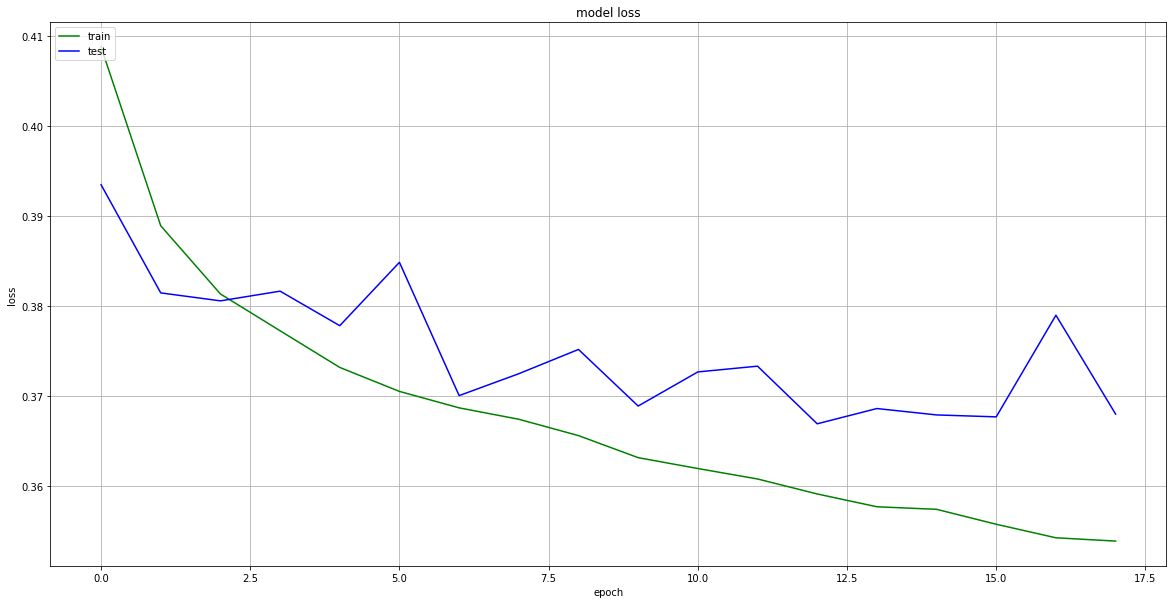

In [ ]:
# Plot learning curve
plt.plot(history.history['loss'] , 'g')
plt.plot(history.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test.values, y_test.values, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
648/648 [==============================] - 2s 4ms/step - loss: 0.4030
test loss, test acc: 0.4030075967311859


In [ ]:
predictions = (model.predict(X_test).flatten() >= 0.5).astype(int)
proba = sum(y_test.values == predictions) / len(predictions)
print("Probability of good prediction with a threshold at 0.5: {}".format(proba))

Probability of good prediction with a threshold at 0.5: 0.8243885377972888


##### Question 2
Evaluate your algorithm on the "real" test dataset: before putting our algorithm in production, we want to evaluate its performances offline. As the main goal is to rank the sales of the homepage, we will observe all the order of the past and try to rank all the sales of the homepage at that time. Then we compute the rank of the sales which generated an order to validate our algorithm.

In the next testset the `id` correspond to all the sales displayed to a user who made an order. Only one sale will have the `label` `1`. This is the sale which generated an order.

You will have compute the mean rank of all positive examples (label=1) when scored and ranked by your algorithm's predictions.
 

##### Solution

In [ ]:
X_test = pd.read_csv('data/2020-08-05_anon.csv.gz', compression="gzip", index_col=0)
y_test = X_test.pop("label")
ids = X_test.pop("id")

In [ ]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352
0,0.030391,0.011099,0.011581,0.004557,0.000000,1.0,0.047619,0.010417,0.018868,0.013333,0.019231,0.014612,0.002747,0.005814,0.047619,0.000227,0.018868,0.000239,0.019231,0.000747,0.002747,0.006098,0.047619,0.000227,0.018868,0.000239,0.019231,0.000747,0.002747,0.0625,0.047619,0.001848,0.018868,0.001905,0.019231,0.003248,0.002747,0.006719,0.000422,0.000431,...,0.055934,0.037037,0.011139,0.046296,0.015033,0.166667,0.044183,0.0,0.007232,0.027491,0.00274,0.027491,0.002740,0.017182,0.00274,0.027491,0.002740,0.047838,0.03,0.033333,0.030000,0.033333,0.03,0.033333,0.03,0.033333,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.002950,0.000000,-1.000000,0.006521,-1.000000,0.013826,0.000000
1,0.040521,0.008796,0.006236,0.027769,0.002747,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.046512,0.285714,0.002040,0.214286,0.002151,0.321429,0.004233,0.098901,0.006098,0.035714,0.000227,0.023810,0.000239,0.035714,0.000247,0.098901,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.016797,0.001617,0.001579,...,0.000000,0.000000,0.000000,0.000737,0.001236,0.000000,0.000000,0.0,0.025475,0.000000,1.00000,0.001301,0.098630,0.000000,1.00000,0.029268,0.008219,0.027172,0.00,1.000000,0.017606,0.100000,0.00,1.000000,0.00,1.000000,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.014749,0.000000,-1.000000,0.000000,-1.000000,0.170096,1.000000
2,0.005789,0.001257,0.000891,0.040080,0.013736,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.001120,0.000070,0.000072,...,0.000000,0.010000,0.009003,0.008604,0.007759,0.000000,0.000000,0.0,0.001334,0.000000,1.00000,0.000000,1.000000,0.000000,1.00000,0.000000,1.000000,0.006697,0.00,1.000000,0.000000,1.000000,0.00,1.000000,0.00,1.000000,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.000983,0.000000,-1.000000,0.010434,-1.000000,0.010289,0.444444
3,0.001447,0.000419,0.000223,0.014002,0.835165,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.001120,0.000281,0.000144,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000265,0.000000,1.00000,0.000000,1.000000,0.000000,1.00000,0.000000,1.000000,0.000000,0.00,1.000000,0.000000,1.000000,0.00,1.000000,0.00,1.000000,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.000000,0.006897,0.408644,0.449299,0.688535,0.691640,0.333333
4,0.023155,0.004398,0.002895,0.057775,0.167582,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.003359,0.001055,0.001077,...,0.019102,0.071197,0.022664,0.018122,0.005619,0.076923,0.016715,0.0,0.009378,0.000000,1.00000,0.001767,0.082192,0.000000,1.00000,0.007067,0.082192,0.005071,0.00,1.000000,0.000000,1.000000,0.00,1.000000,0.00,1.000000,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.011799,0.003448,0.431565,0.411477,0.428061,0.880386,0.666667


In [ ]:
predictions = (model.predict(X_test.values))

In [ ]:
pred = np.concatenate(predictions,axis=0)
X_test['prediction'] = pred.tolist()
X_test['id'] = ids
X_test['label'] = y_test
X_test['rank'] =X_test.groupby('id')['prediction'].rank('dense',ascending = False)

orders = X_test[X_test['label'] ==1]
mean_rank = orders['rank'].mean()

In [ ]:
mean_rank

3.5491

##### Question 3
In a production setting (real time answers, lots of users etc.):
- What are the advantages/drawbacks of this approach ?
- Which solution can we use to reduce these drawbacks ?

##### Answer

**Advantages**:
1. DNN is composite in the sense that the function is trained end-to-end. In practice, when recommendation often involves multi-modal data, DNN offers an attractive alternative to other methods because of its joint representation learning. Multiple neural building blocks can be composed into a single differentiate function

2. DNN techniques have high flexibility, not just because it can be easily combined with other neural structures to formulate hybrid models to accommodate different needs, its hyperparameters can also be fine-tuned to achieve better performance. 

3. DNN is capable of handling non-linearity in data. It's capable of capturing intricate user-item interaction patterns. 


**Disadvantages**:
1. DNN requires relatively large amount of data to perform their functions, which is not always available. 

2. DNN requires fine-tuning of the hyperparameters that can be challenging.

3. In general, DNN has low interpretability, which is not desirable in a production setting. 

**Solution**:
We can use cross-validation or grid-search to improve our DNN implementation and to avoid over-fitting. We can also use GPU to improve the efficiency of our implementation.

